<a href="https://www.cognitiveclass.ai"><img src = "https://cognitiveclass.ai/wp-content/themes/bdu3.0/static/images/cc-logo.png" width = 300, align = "center"></a>

<h1 align=center><font size = 5>CNN on SETI Dataset using TF</font></h1>


In this notebook, we use Convolutional Neural Network to classify the SETI Image files.

### Import necessary libraries

In [1]:
import requests
import json
#import ibmseti
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pickle
import time
!sudo pip install sklearn
import os
from sklearn.metrics import confusion_matrix
from sklearn import metrics

[sudo] password for sd22-2e55b7df66e8c3-b01c69100280: 



### Import dataset reader

In [2]:
!wget --output-document SETI.zip  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
!unzip -o SETI.zip
import SETI

--2017-05-24 18:46:43--  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
Resolving ibm.box.com (ibm.box.com)... 107.152.25.197, 107.152.24.197
Connecting to ibm.box.com (ibm.box.com)|107.152.25.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip [following]
--2017-05-24 18:46:43--  https://ibm.ent.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
Resolving ibm.ent.box.com (ibm.ent.box.com)... 107.152.25.211, 107.152.24.211
Connecting to ibm.ent.box.com (ibm.ent.box.com)|107.152.25.211|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/s2_lVJepkZnrb_1Shd6kaEgHAevGs0Pd5Pr4PxpSpWc1x1Bn03Y-XRIHdHRDC3cFDI6wolqW4T4AyLiTRP6bYTFxXRMVMEHTfqHUVhpweNblBnDmW7o1cX-Su0YHKR5c0jUKxAUIA9_xo76GdqzUEvCJ7B8A1JeuNRYKl8pkPr2xFveYYwaiTKu5eboE2-PyrAhccwzBbasH7F6CCUWZUznvJnjyit0vxLoY-9mPtoRMCsfcmPBG3qbSb

### Download data

In [3]:
ds_directory = 'SETI/SETI_ds_64x128/'
ds_name = 'SETI/SETI64x128.tar.gz'

In [4]:
print os.popen("ls -lrt "+ ds_directory).read() # to verify

total 7152
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users 1665328 May 22 21:11 train-images-idx3-ubyte.gz
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users     306 May 22 21:11 train-labels-idx1-ubyte.gz
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users  765379 May 22 21:11 test-images-idx3-ubyte.gz
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users     172 May 22 21:11 test-labels-idx1-ubyte.gz



### Load data SETI

In [5]:
#from tensorflow.examples.tutorials.mnist import input_data
#dataset = input_data.read_data_sets("MNIST_data/", one_hot=True)
dataset = SETI.read_data_sets(ds_directory, one_hot=True, validation_size=0)
dataset.train.images.shape

Extracting SETI/SETI_ds_64x128/train-images-idx3-ubyte.gz
Extracting SETI/SETI_ds_64x128/train-labels-idx1-ubyte.gz
Extracting SETI/SETI_ds_64x128/test-images-idx3-ubyte.gz
Extracting SETI/SETI_ds_64x128/test-labels-idx1-ubyte.gz


(694, 8192)

## Network Parameters

In [6]:
# Parameters
decay_rate=0.98
decay_steps=1000
learning_rate = 0.05
training_epochs = 20
batch_size = 50
display_step = 100

#check point directory
chk_directory = 'SETI/save/'
checkpoint_path = chk_directory+'model.ckpt'


n_classes = 4 # number of possible classifications for the problem
dropout = 0.50 # Dropout, probability to keep units

height = 64 # height of the image in pixels 
width = 128 # width of the image in pixels 
n_input = width * height # number of pixels in one image 


### Inputs

In [7]:
x  = tf.placeholder(tf.float32, shape=[None, n_input])
y_ = tf.placeholder(tf.float32, shape=[None, n_classes])

In [8]:
x_image = tf.reshape(x, [-1,height,width,1]) 
x_image

<tf.Tensor 'Reshape:0' shape=(?, 64, 128, 1) dtype=float32>

#### Convolutional Layer 1

In [9]:
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs
convolve1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1
h_conv1 = tf.nn.relu(convolve1)
conv1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #max_pool_2x2
conv1

<tf.Tensor 'MaxPool:0' shape=(?, 32, 64, 32) dtype=float32>

#### Convolutional Layer 2

In [10]:
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) #need 64 biases for 64 outputs
convolve2= tf.nn.conv2d(conv1, W_conv2, strides=[1, 1, 1, 1], padding='SAME')+ b_conv2
h_conv2 = tf.nn.relu(convolve2)
conv2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 4, 4, 1], padding='SAME') #max_pool_2x2
conv2

<tf.Tensor 'MaxPool_1:0' shape=(?, 8, 16, 64) dtype=float32>

#### Convolutional Layer 3

#### Convolutional Layer 4

#### Fully Connected Layer 1

In [11]:
input_layer = conv2
dim = input_layer.get_shape().as_list()
dim

[None, 8, 16, 64]

In [12]:
dims= dim[1]*dim[2]*dim[3]
nodes1 = 1024
prv_layer_matrix = tf.reshape(input_layer, [-1, dims])
W_fc1 = tf.Variable(tf.truncated_normal([dims, nodes1], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[nodes1])) # need 1024 biases for 1024 outputs
h_fcl1  = tf.matmul(prv_layer_matrix, W_fc1) + b_fc1
fc_layer1 = tf.nn.relu(h_fcl1) # ???
fc_layer1


<tf.Tensor 'Relu_2:0' shape=(?, 1024) dtype=float32>

#### Droupout 1

In [13]:
keep_prob = tf.placeholder(tf.float32)
layer_drop1 = tf.nn.dropout(fc_layer1, keep_prob)

#### Fully Connected Layer 2

#### Droupout 2

#### Readout Layer

In [14]:
W_fc = tf.Variable(tf.truncated_normal([nodes1, n_classes], stddev=0.1)) #1024 neurons
b_fc = tf.Variable(tf.constant(0.1, shape=[n_classes])) # 10 possibilities for classes [0,1,2,3]
fc = tf.matmul(layer_drop1, W_fc) + b_fc
y_CNN= tf.nn.softmax(fc)

#### Loss function

In [15]:
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_l4_conv), reduction_indices=[1]))
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_CNN, labels=y_))

#### Training


In [16]:
# Create a variable to track the global step.
global_step = tf.Variable(0, trainable=False)

# create learning_decay
lr = tf.train.exponential_decay( learning_rate,
                                 global_step,
                                 decay_steps,
                                 decay_rate, staircase=True )

In [17]:
# Use the optimizer to apply the gradients that minimize the loss
# (and also increment the global step counter) as a single training step.
optimizer = tf.train.GradientDescentOptimizer(lr)

train_op = optimizer.minimize(cross_entropy, global_step=global_step)
#train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

#### Evaluation

In [18]:
correct_prediction = tf.equal(tf.argmax(y_CNN,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Create checkpoint directory

In [19]:
directory = os.path.dirname(chk_directory)
try:
    os.stat(directory)
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    print ckpt
except:
    os.mkdir(directory) 

model_checkpoint_path: "SETI/save/model.ckpt-240"
all_model_checkpoint_paths: "SETI/save/model.ckpt-240"



## Training

In [20]:
# Initializing the variables
init = tf.initialize_all_variables()

In [23]:
loss_values = []
with tf.Session() as sess:

    
    X_test = dataset.test.images
    y_test = dataset.test.labels
    sess.run(init)
    saver = tf.train.Saver(tf.all_variables())
    
    # load previously trained model if appilcable
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    if ckpt:
        print "loading model: ",ckpt.model_checkpoint_path
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    
    #step = 0
    num_examples = dataset.train.num_examples
    # Training cycle
    for epoch in range(training_epochs):
        avg_loss = 0.
        avg_accuracy = 0.
        #dataset.shuffle_data()
        total_batch = int(num_examples / batch_size)

        # Loop over all batches
        for step in range(total_batch):
            start = time.time()
            x_batch, y_batch = dataset.train.next_batch(batch_size,shuffle=True)
            train_op.run(feed_dict={x: x_batch, y_: y_batch, keep_prob: dropout})
            loss, acc = sess.run([cross_entropy, accuracy], feed_dict={x: x_batch,y_: y_batch,keep_prob: 1.})
            
            
            end = time.time()
            
            avg_loss += loss / total_batch
            avg_accuracy += acc / total_batch
            if step % display_step == 1000:

                
                # Calculate batch loss and accuracy
                loss, acc = sess.run([cross_entropy, accuracy], feed_dict={x: x_batch,y_: y_batch,keep_prob: 1.})
                #train_accuracy = accuracy.eval(feed_dict={x:x_batch, y_: y_batch,  keep_prob: 0.5})

                test_accuracy = sess.run(accuracy, feed_dict={x: X_test[0:100], y_: y_test[0:100], keep_prob: 1.})

                print("Iter " + str(step) + \
                    ", Training time= " + "{:.5f}".format(end - start) + \
                    ", Minibatch Loss= " +  "{:.6f}".format(loss) +  \
                    ", Training Accuracy= " + "{:.5f}".format(acc)  + \
                    ", Test Accuracy= " + "{:.5f}".format(test_accuracy) )
        
        # save model every 1 epochs
        if epoch >= 0 and epoch % 1 == 0:
            # Save model
            #print ("model saved to {}".format(checkpoint_path))
            #saver.save(sess, checkpoint_path, global_step = epoch)
            plr = sess.run(lr)
            loss_values.append(avg_loss)
            #print(sess.run(tf.train.global_step()))
            print "Epoch:", '%04d' % (epoch+1), "lr=", "{:.9f}".format(plr), "cost=", "{:.9f}".format(avg_loss) ,"Acc=", "{:.9f}".format(avg_accuracy)

    print("Optimization Finished!")
    print ("model saved to {}".format(checkpoint_path))
    saver.save(sess, checkpoint_path, global_step = (epoch+1)*step)

    
    
    # Calculate accuracy for test images
    #print("Testing Accuracy:", sess.run(accuracy, feed_dict={x: X_test[0:30], y_: y_test[0:30], keep_prob: 1.}))
        
    # Find the labels of test set
    y_pred_lb = sess.run(tf.argmax(y_CNN,1), feed_dict={x: X_test[0:100], y_: y_test[0:100], keep_prob: 1.})
    y_pred = sess.run(y_CNN, feed_dict={x: X_test[0:100], y_: y_test[0:100], keep_prob: 1.})
    
    # lets save kernels
    kernels_l1 = sess.run(tf.reshape(tf.transpose(W_conv1, perm=[2, 3, 0, 1]),[32,-1]))
    kernels_l2 = sess.run(tf.reshape(tf.transpose(W_conv2, perm=[2, 3, 0, 1]),[32*64,-1]))

loading model:  SETI/save/model.ckpt-240
Epoch: 0001 lr= 0.050000001 cost= 1.172027258 Acc= 0.527692309
Epoch: 0002 lr= 0.050000001 cost= 1.185723607 Acc= 0.504615380
Epoch: 0003 lr= 0.050000001 cost= 1.169946863 Acc= 0.523076917
Epoch: 0004 lr= 0.050000001 cost= 1.155229550 Acc= 0.563076920
Epoch: 0005 lr= 0.050000001 cost= 1.171567935 Acc= 0.526153844
Epoch: 0006 lr= 0.050000001 cost= 1.177281050 Acc= 0.512307690
Epoch: 0007 lr= 0.050000001 cost= 1.159419537 Acc= 0.553846148
Epoch: 0008 lr= 0.050000001 cost= 1.155651138 Acc= 0.540000003
Epoch: 0009 lr= 0.050000001 cost= 1.178517287 Acc= 0.524615382
Epoch: 0010 lr= 0.050000001 cost= 1.163363163 Acc= 0.538461536
Epoch: 0011 lr= 0.050000001 cost= 1.169976308 Acc= 0.547692313
Epoch: 0012 lr= 0.050000001 cost= 1.170629538 Acc= 0.519999995
Epoch: 0013 lr= 0.050000001 cost= 1.170866223 Acc= 0.530769231
Epoch: 0014 lr= 0.050000001 cost= 1.171847884 Acc= 0.523076924
Epoch: 0015 lr= 0.050000001 cost= 1.164373132 Acc= 0.552307693
Epoch: 0016 lr

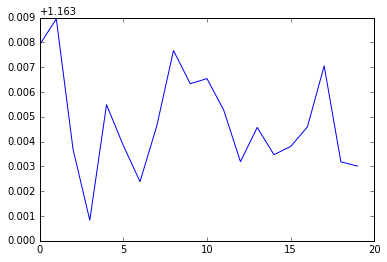

In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot([np.mean(loss_values[i:i+5]) for i in range(len(loss_values))])
plt.show()


## Evaluation

In [35]:
y_ = np.argmax(y_test[0:100],1) # ground truth
print metrics.classification_report(y_true= y_, y_pred= y_pred_lb)
print metrics.confusion_matrix(y_true= y_, y_pred= y_pred_lb)
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true= y_, y_pred= y_pred_lb) )
print("Log Loss: %0.6f" % metrics.log_loss(y_true= y_, y_pred= y_pred, labels=range(4)) )

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        25
          1       0.00      0.00      0.00        28
          2       0.30      1.00      0.46        23
          3       1.00      1.00      1.00        24

avg / total       0.31      0.47      0.35       100

[[ 0  0 25  0]
 [ 0  0 28  0]
 [ 0  0 23  0]
 [ 0  0  0 24]]
Classification accuracy: 0.470000
Log Loss: 0.972129


### Viz

In [ ]:
!wget --output-document utils1.py http://deeplearning.net/tutorial/code/utils.py
import utils1
from utils1 import tile_raster_images

In [ ]:
#from utils import tile_raster_images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(kernels_l1, img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

In [ ]:
image = Image.fromarray(tile_raster_images(kernels_l2, img_shape=(5, 5) ,tile_shape=(4, 12), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

In [ ]:
import numpy as np
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage1 = X_test[3]
plt.imshow(np.reshape(sampleimage1,[64,128]), cmap="gray")

In [ ]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    saver = tf.train.Saver(tf.all_variables())
    
    # load previously trained model if appilcable
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    if ckpt:
        print "loading model: ",ckpt.model_checkpoint_path
        saver.restore(sess, ckpt.model_checkpoint_path)
    ActivatedUnits1 = sess.run(convolve1,feed_dict={x:np.reshape(sampleimage1,[1,64*128],order='F'),keep_prob:1.0})
    plt.figure(1, figsize=(20,20))
    n_columns = 3
    n_rows = 3
    for i in range(9):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(ActivatedUnits1[0,:,:,i], interpolation="nearest", cmap="gray")


<h3>Authors:</h3>
<article class="teacher">
<div class="teacher-image" style="    float: left;
    width: 115px;
    height: 115px;
    margin-right: 10px;
    margin-bottom: 10px;
    border: 1px solid #CCC;
    padding: 3px;
    border-radius: 3px;
    text-align: center;"><img class="alignnone wp-image-2258 " src="https://ibm.box.com/shared/static/tyd41rlrnmfrrk78jx521eb73fljwvv0.jpg" alt="Saeed Aghabozorgi" width="178" height="178" /></div>
<h4>Saeed Aghabozorgi</h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is Sr. Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>
</article>


<hr>
Learn more about __Deep Leaning and TensorFlow:__

<a href="https://cognitiveclass.ai/courses/deep-learning-tensorflow/"><img src = "https://cognitiveclass.ai/wp-content/uploads/2017/03/TF_course_logo-1024x369.png" width = 500, align = "center"></a>